# Analysis of WGS mutations
## Read data

In [1]:
source("../data/env/variables.R")
source("~/wisdom/r/data_analysis_environment.R")
source("~/wisdom/r/clean_theme.R")

options("readr.num_columns" = 0)

# read switch information
switches <- read_tsv("../data/pancancer/candidateList_full.tsv") %>%
    filter(Reliable==1)

# read switch information
wgs.patient_info <- read_tsv("../data/mutations/wgs_mutations.txt") %>%
    mutate(Patient = paste0(Patient,"T"))

# read mutual exclusion info
wgs <- read_tsv("../data/pancancer/mutations/gene_wgs_mutations_all_switches.txt") %>%
    merge(switches) %>%
    mutate(co = MS/(MS+S))

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats


## Co-occurrence analysis
We define co-occurrence as MS/(MS+S) ie the proportion of switches that happen in a mutated sample.


Attaching package: ‘scales’

The following object is masked from ‘package:purrr’:

    discard

The following objects are masked from ‘package:readr’:

    col_factor, col_numeric

Loading required package: RColorBrewer


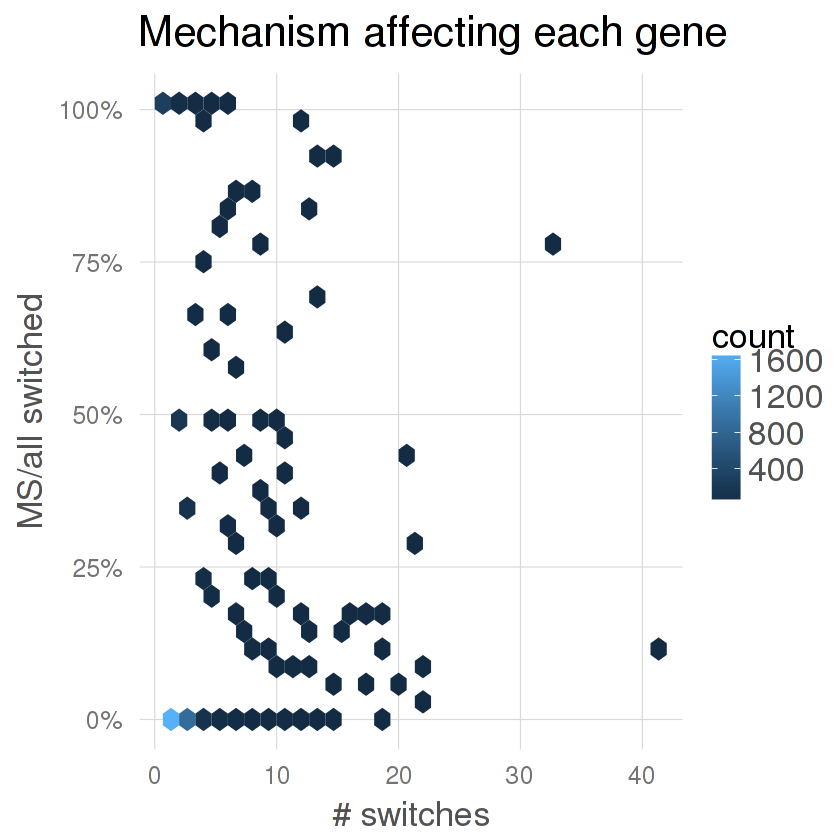

In [2]:
library(scales)
ggplot(wgs, aes(x=S+MS,y=co)) + 
    stat_binhex() +
    labs(x="# switches",y="MS/all switched",title="Mechanism affecting each gene") +
    clean_theme() +
    theme(legend.position="right") +
    scale_y_continuous(labels = percent)

As we see, co-occurrence of switches and mutations is not frequent, as happens with WES mutations. However, there are some cases, even at higher counts, where the co-occurrence is pretty high. We will focus on the cases that involve a functional switch.

[1] 16

[1] 1

[1] "KDM5C"

[1] 0

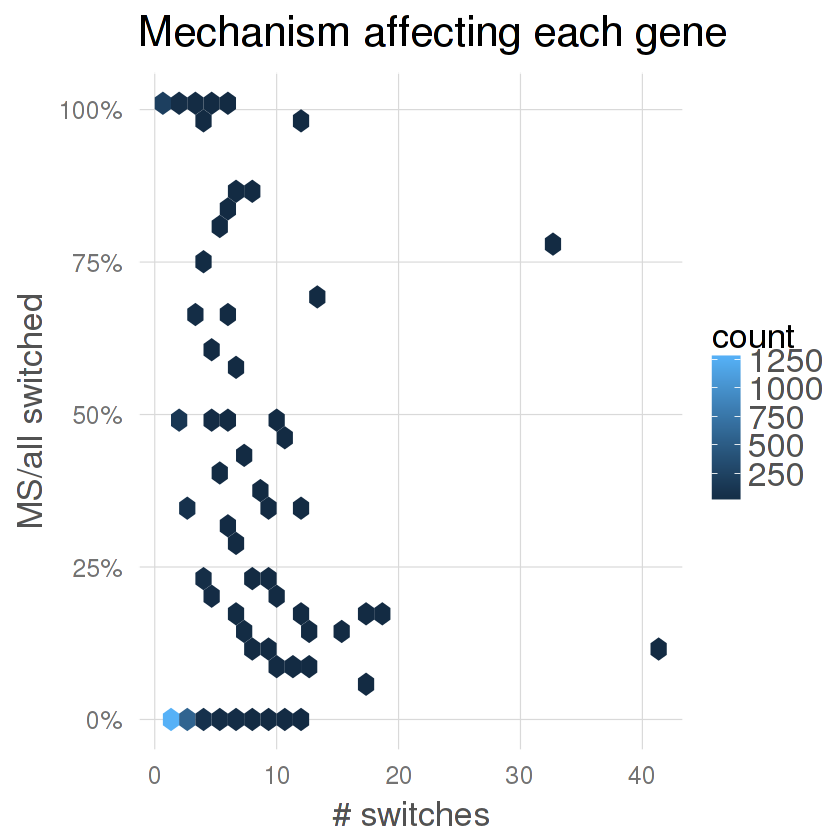

In [3]:
wgs <- subset(wgs,IsFunctional==1)

ggplot(wgs, aes(x=S+MS,y=co)) + 
    stat_binhex() +
    labs(x="# switches",y="MS/all switched",title="Mechanism affecting each gene") +
    clean_theme() +
    theme(legend.position="right") +
    scale_y_continuous(labels = percent)

wgs %>% filter(p.o < 0.05) %>% nrow
wgs %>% filter(p.o < 0.05 & Driver==1) %>% nrow
wgs %>% filter(p.o < 0.05 & Driver==1) %>% .$Symbol
wgs %>% filter(p.adjust(p.o) < 0.05) %>% nrow

In 16 cases the co-occurrence is higher than expected by chance, 1 of which happen in a driver. However, after correction for multiple testing this is a number that we expect by chance.

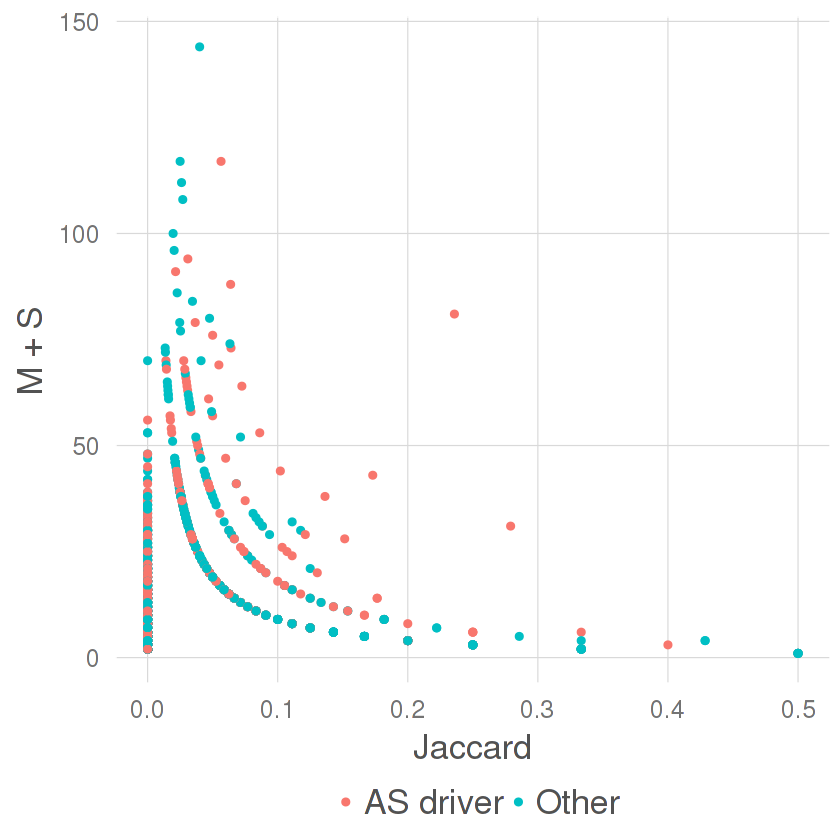

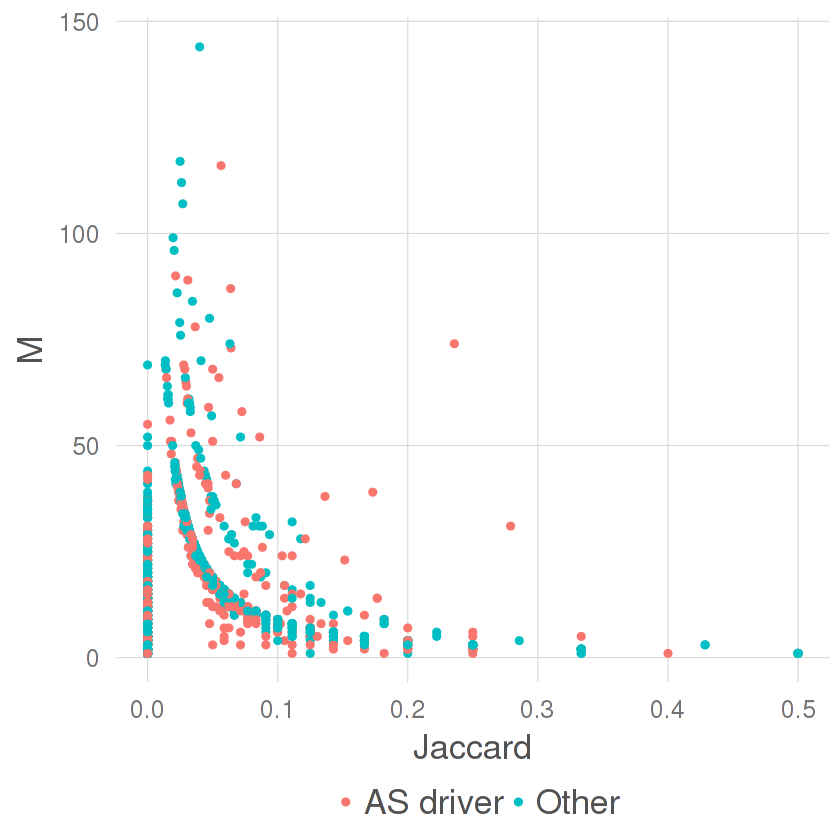

In [4]:
# some measures of mutual exclusion
wgs %>%
    mutate(Jaccard = MS/(M+S+MS)) %>%
    ggplot(aes(x = Jaccard, y = M + S, color = ifelse(Candidate==1, "AS driver", "Other"))) +
        geom_point() +
        clean_theme() + 
        theme(legend.position="bottom") +
        labs(color = "")

wgs %>%
    mutate(Jaccard = MS/(M+S+MS)) %>%
    ggplot(aes(x = Jaccard, y = M, color = ifelse(Candidate==1, "AS driver", "Other"))) +
        geom_point() +
        clean_theme() + 
        theme(legend.position="bottom") +
        labs(color = "")

In [5]:
# check those outliers
wgs %>% mutate(Jaccard = MS/(M+S+MS)) %>% filter((M + S) > 25 & Jaccard > 0.2)

GeneId,Symbol,Normal_transcript,Tumor_transcript,MS,M,S,N,p.o,Normal_protein,⋯,S.pam,N.pam,p.pam.me,MS.mut,M.mut,S.mut,N.mut,p.mut.o,co,Jaccard
25817,FAM19A5,uc003bim.3,uc003bio.3,25,74,7,25,0.4487518,Q7Z5A7,⋯,197,3390,0.9802310,25,74,7,25,0.4487518,0.78125,0.2358491
56243,KIAA1217,uc001iru.3,uc001irx.2,12,31,0,0,1.0000000,Q5T5P2,⋯,63,3479,0.7372839,12,31,0,0,1.0000000,1.00000,0.2790698


## Driver behaviour


	Wilcoxon rank sum test with continuity correction

data:  wgs$co[wgs$Driver == 1] and wgs$co[wgs$Driver == 0]
W = 142490, p-value = 0.005189
alternative hypothesis: true location shift is not equal to 0


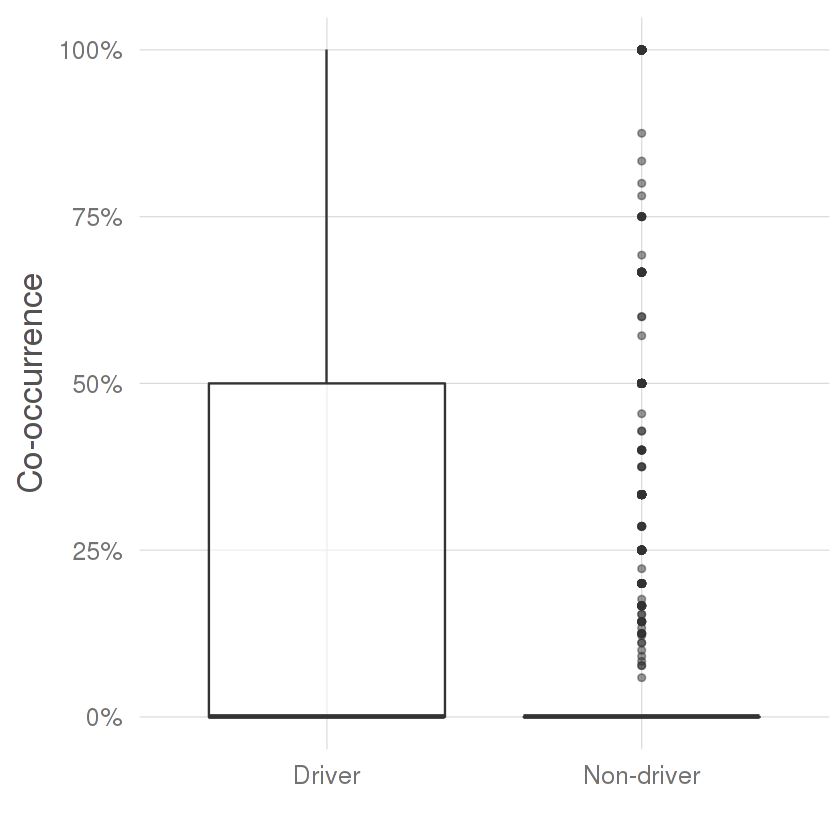

In [6]:
wgs %>%
    mutate(Driver = ifelse(Driver==1, "Driver", "Non-driver")) %>%
    ggplot(aes(y=co,x=Driver)) +
        geom_boxplot(alpha=0.5) +
        clean_theme() +
        labs(x="",y="Co-occurrence")  +
        theme(legend.position="bottom") +
        scale_y_continuous(labels = percent)

wilcox.test(wgs$co[wgs$Driver==1],wgs$co[wgs$Driver==0])

Potential drivers co-occur with mutations more than the rest of the genes. Drivers are not discovered based on non-protein affecting mutations. And, although we already observed a higher co-occurence between this and PAM data (see [WES analysis](wes_genes.ipynb), in this case the values of co-occurrence are higher. Hence, this could mean that the splicing change is caused by a mutation AND selected. To avoid sample-biases, it will be interesting to check if the same patients that undergo a switch have a high co-occurrence with mutations in other random gene, which would mean that the alterations occur in patients with a high mutation rate.

In [7]:
# format data
S <- strsplit(wgs$Patients_affected,",") %>%
    set_names(wgs$GeneId)
M <- split(wgs.patient_info$Patient, f=wgs.patient_info$GeneId)

# for every switch, we sample the same patients i times
i = 100
co <- lapply(S,function(x){
    lapply(sample(M,i,replace = TRUE),function(y){
        length(intersect(x,y))/length(x)
    })}) %>% lapply(function(x){do.call("rbind",x)})

sampling <- data.frame(Driver=c(rep("Driver",i*sum(wgs$Driver==1)),rep("Non-driver",i*sum(wgs$Driver==0))),
                       co=c(as.numeric(do.call("rbind",co[wgs$Driver==1])),
                            as.numeric(do.call("rbind",co[wgs$Driver==0]))))

wilcox.test(sampling$co[sampling$Driver=="Driver"],sampling$co[sampling$Driver=="Non-driver"],alternative="greater")


	Wilcoxon rank sum test with continuity correction

data:  sampling$co[sampling$Driver == "Driver"] and sampling$co[sampling$Driver == "Non-driver"]
W = 1266700000, p-value = 0.6
alternative hypothesis: true location shift is greater than 0


When considering the random sampling, the higher co-occurrence in drivers is lost.

In [8]:
wilcox.test(wgs$co[wgs$Driver==1],sampling$co[sampling$Driver=="Driver"],alternative="greater")
wilcox.test(wgs$co[wgs$Driver==0],sampling$co[sampling$Driver=="Non-driver"],alternative="greater")


	Wilcoxon rank sum test with continuity correction

data:  wgs$co[wgs$Driver == 1] and sampling$co[sampling$Driver == "Driver"]
W = 619400, p-value = 6.486e-08
alternative hypothesis: true location shift is greater than 0



	Wilcoxon rank sum test with continuity correction

data:  wgs$co[wgs$Driver == 0] and sampling$co[sampling$Driver == "Non-driver"]
W = 342920000, p-value < 2.2e-16
alternative hypothesis: true location shift is greater than 0


However, non-random data present higher levels of co-occurrence, implying some biological implication.

## Conclusion

Mutations are behind some of the switches, particularly in driver genes. However, this enrichment is partially due to the patients, but still this cannot explain all the effect we see.